In [ ]:
 %%capture
!pip install transformers transformers[sentencepiece]
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install huggingface_hub
!pip install sentencepiece

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from matplotlib import pyplot as plt
import spacy
from wordcloud import WordCloud

def create_word_cloud(series):
    # Combine all text from the series into a single string
    text = ' '.join(series.tolist())

    # Load spaCy's English language model
    nlp = spacy.load('en_core_web_sm')

    # Create a set of spaCy's English stop words
    stopwords = set(nlp.Defaults.stop_words)

    # Step 4: Create an instance of WordCloud and generate the word cloud
    wordcloud = WordCloud(stopwords=stopwords).generate(text)

    # Step 6: Display the word cloud using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

import re

def remove_mental_health_references(df):
  unique_labels = list(df.subreddit.unique())
  unique_labels.extend(list(map(lambda x: x.lower(), unique_labels)))
  unique_labels.extend(list(map(lambda x: x.upper(), unique_labels)))
  unique_labels = set(unique_labels)
  pattern = '|'.join(unique_labels)
  df.body = df.body.str.replace(pattern, '', regex=True)
  return df


In [ ]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def prepare_dataframe(df):
  # Concatenate title and body
  df['body'] = df.body.fillna('')
  df['body'] = df.body.str.cat(df.title, sep=' ')

  # Removed deleted posts
  df = df[~df.author.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[removed\]')]
  df = df[~df.body.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[deleted by user\]')]

  # Removed moderador posts
  df = df[df.author!='AutoModerator']

  return df[['body', 'subreddit']]


In [ ]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import numpy as np
import torch

name_id_model = "bhadresh-savani/albert-base-v2-emotion"
dataset = load_dataset("solomonk/reddit_mental_health_posts")

def not_none(example):
    return example['body'] is not None



# dataset = dataset.filter(not_none)

df = dataset["train"].to_pandas()
df = prepare_dataframe(df).reset_index(drop=True)
df = df.pipe(remove_mental_health_references)
dataset = Dataset.from_pandas(df)

  0%|          | 0/1 [00:00<?, ?it/s]

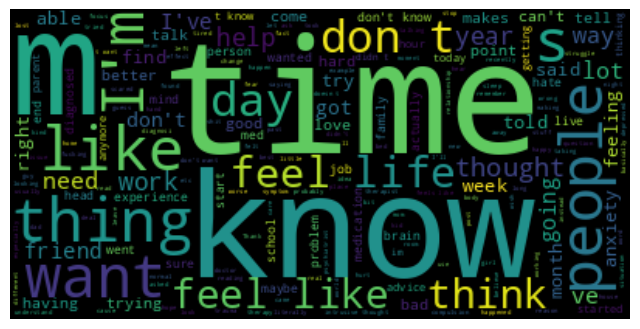

In [ ]:
create_word_cloud(df.body)

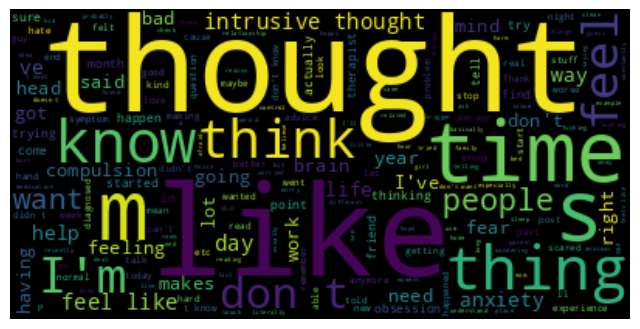

In [ ]:
create_word_cloud(df[df.subreddit == "OCD"].body)

In [ ]:
dataset_sampled = dataset.train_test_split(test_size=0.7, seed=42)['train']

train_val_test = dataset_sampled.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_test['train']
test_val_dataset = train_val_test['test']

test_val_split = test_val_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = test_val_split['train']
test_dataset = test_val_split['test']

columns_to_keep = ['body', 'subreddit']

columns_to_remove = [col for col in dataset_sampled.column_names if col not in columns_to_keep]

train_dataset = train_dataset.remove_columns(columns_to_remove)
validation_dataset = validation_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

le = LabelEncoder()

le.fit(dataset_sampled['subreddit'])

def encode_labels(example):
    example['subreddit'] = le.transform([example['subreddit']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
validation_dataset = validation_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

def prepare_data(example):
    encoding = tokenizer.encode_plus(
        example['body'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt',
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(example['subreddit'], dtype=torch.long)
    }

train_dataset = train_dataset.map(prepare_data)
validation_dataset = validation_dataset.map(prepare_data)
test_dataset = test_dataset.map(prepare_data)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='albert_classification_reddit',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    push_to_hub=True,

)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)


trainer.train()

trainer.evaluate(test_dataset)


Map:   0%|          | 0/20343 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Map:   0%|          | 0/20343 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Cloning https://huggingface.co/Frorozcol/albert_classification_reddit into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/44.6M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.81k/3.81k [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##6       | 1.00k/3.81k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/44.6M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,1.162900
1000,0.750700
1500,0.618500
2000,0.474900
2500,0.456800


Several commits (2) will be pushed upstream.
Several commits (3) will be pushed upstream.
Several commits (4) will be pushed upstream.
Several commits (5) will be pushed upstream.


{'eval_loss': 0.48008185625076294,
 'eval_accuracy': 0.8293354305937869,
 'eval_f1': 0.8290025460846228,
 'eval_runtime': 100.5666,
 'eval_samples_per_second': 25.287,
 'eval_steps_per_second': 1.581,
 'epoch': 2.0}

In [ ]:
from torch.nn.functional import cross_entropy
# Get the predictions, ground truth values, and loss for each data point in the test dataset
prediction_output = trainer.predict(test_dataset)

predictions = np.argmax(prediction_output.predictions, axis=-1)
labels = prediction_output.label_ids
# Get the loss
torch_tensor = torch.from_numpy(prediction_output.predictions)
labels_torch = torch.tensor(labels)
loss = cross_entropy(torch_tensor,labels_torch, reduction="none")

# Create a dataframe
import pandas as pd

df = pd.DataFrame({'predictions': predictions, 'ground_truth': labels, "losses":loss })


In [ ]:
df.predictions = le.inverse_transform(df.predictions)
df.ground_truth = le.inverse_transform(df.ground_truth)
df["text"] = test_dataset["body"]
df["len"] = df.text.str.len()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns

def generate_classification_report(predictions, labels, classes):
    """
    Generate and print the classification report.

    Args:
        predictions (list or numpy array): Predicted labels.
        labels (list or numpy array): True labels.
    """
    report = classification_report(labels, predictions, target_names=classes)
    print("Classification Report:")
    print(report)

def plot_confusion_matrix(predictions, labels, classes):
    """
    Calculate and plot the confusion matrix using Seaborn.

    Args:
        predictions (list or numpy array): Predicted labels.
        labels (list or numpy array): True labels.
        classes (list): List of class labels.
    """
    confusion = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
generate_classification_report(predictions, labels,  le.classes_)

Classification Report:
              precision    recall  f1-score   support

        ADHD       0.84      0.88      0.86       600
         OCD       0.85      0.85      0.85       720
   aspergers       0.82      0.76      0.79       410
  depression       0.78      0.82      0.80       440
        ptsd       0.82      0.79      0.80       373

    accuracy                           0.83      2543
   macro avg       0.83      0.82      0.82      2543
weighted avg       0.83      0.83      0.83      2543



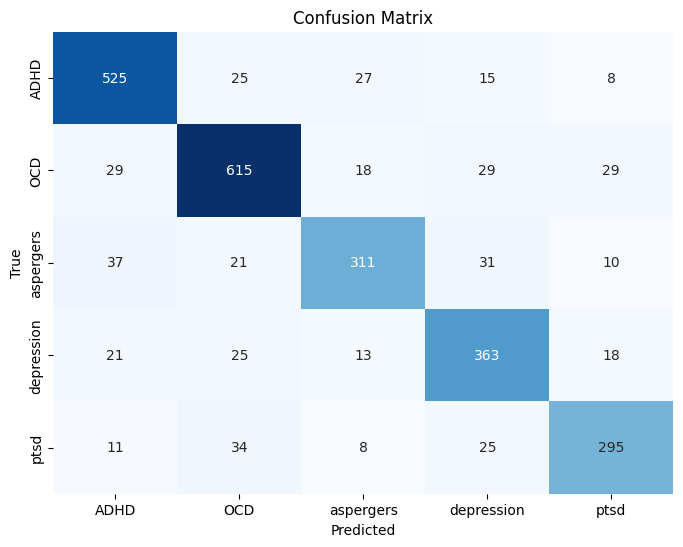

In [ ]:
plot_confusion_matrix(predictions, labels, le.classes_)

In [ ]:
df_better_loss = df.sort_values("losses").head(100)

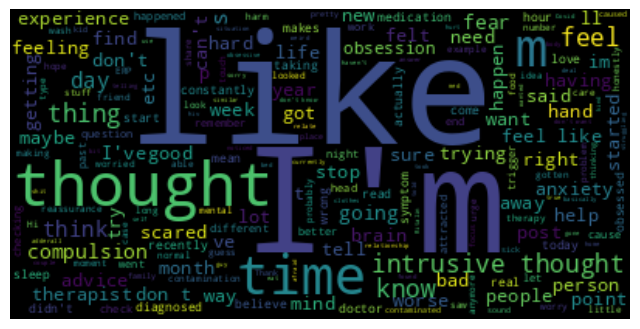

In [ ]:
create_word_cloud(df_better_loss.text)

<Axes: xlabel='ground_truth', ylabel='len'>

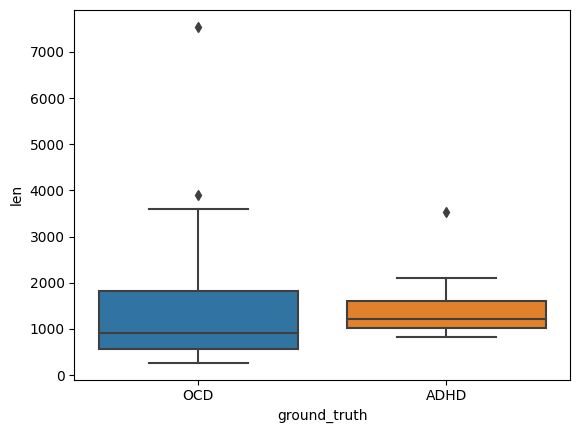

In [ ]:

sns.boxplot(df_better_loss, x= "ground_truth", y="len")

In [ ]:
df.sort_values("losses").tail(100)

,predictions,ground_truth,losses,text,len
574,depression,ptsd,2.908878,I'm sure everyone knows the feeling of going t...,2211
2291,depression,aspergers,2.913235,I am 19M and I learned to accept the fact that...,836
33,depression,aspergers,2.916588,My mental state's not very good right now. I s...,624
1194,depression,ptsd,2.928282,So why did i cry the entire hour home? Im not ...,282
299,depression,OCD,2.932398,I often think about like a lens through which...,547
...,...,...,...,...,...
1652,ptsd,aspergers,5.569302,Just want to share some support for those who ...,686
1310,ADHD,depression,5.604211,I booked an initial appointment with a psychol...,468
1328,ptsd,ADHD,5.652349,tldr: title\n\nI saw the post about someone go...,1753
188,ADHD,depression,5.922390,I'm 20F and I'm a junior in college. I can't b...,747


In [ ]:
df.groupby("ground_truth"	).describe()

losses                                                    \
              count      mean       std       min       25%       50%   
ground_truth                                                            
ADHD          600.0  0.359550  0.808909  0.002999  0.012062  0.039723   
OCD           720.0  0.379963  0.800765  0.002409  0.005250  0.018561   
aspergers     410.0  0.653205  1.119763  0.003945  0.011732  0.073518   
depression    440.0  0.586533  0.998347  0.022249  0.060899  0.147956   
ptsd          373.0  0.551358  0.999630  0.007121  0.017383  0.060366   

                                    len                                   \
                   75%       max  count         mean          std    min   
ground_truth                                                               
ADHD          0.226480  6.974964  600.0  1053.340000   792.115266  325.0   
OCD           0.271983  5.310925  720.0   857.683333  1006.004460   10.0   
aspergers     0.786436  5.569302  410.0   952.956098  1277.526864   31.0   
depression    0.585073  5.922390  440.0   928.729545   986.663318   25.0   
ptsd          0.535308  5.393200  373.0  1131.603217  1082.853500   44.0   

                                               
                 25%    50%      75%      max  
ground_truth                                   
ADHD          561.75  814.0  1273.75   5914.0  
OCD           311.75  559.0  1050.25  13446.0  
aspergers     329.00  628.5  1097.50  17738.0  
depression    292.00  652.5  1266.25   7370.0  
ptsd          443.00  824.0  1482.00   7893.0

In [ ]:
df.groupby("predictions").describe()

losses                                                    \
             count      mean       std       min       25%       50%   
predictions                                                            
ADHD         623.0  0.447312  0.923196  0.002999  0.012681  0.042411   
OCD          720.0  0.392361  0.878223  0.002409  0.005250  0.018561   
aspergers    377.0  0.473631  0.894513  0.003945  0.010656  0.058367   
depression   463.0  0.666580  1.026239  0.022249  0.064442  0.167811   
ptsd         360.0  0.479131  0.937867  0.007121  0.016973  0.049663   

                                   len                                   \
                  75%       max  count         mean          std    min   
predictions                                                               
ADHD         0.302200  5.922390  623.0  1032.674157   781.792399  155.0   
OCD          0.271983  6.974964  720.0   845.637500  1029.374185   10.0   
aspergers    0.518863  5.310925  377.0  1009.899204  1309.260320   31.0   
depression   0.775580  5.459873  463.0   900.654428   876.253221   25.0   
ptsd         0.449680  5.652349  360.0  1169.519444  1164.014633  110.0   

                                             
               25%    50%      75%      max  
predictions                                  
ADHD         565.5  809.0  1219.00   5914.0  
OCD          274.5  547.0  1020.00  13446.0  
aspergers    346.0  668.0  1204.00  17738.0  
depression   293.5  644.0  1255.00   6571.0  
ptsd         414.0  840.0  1525.75   7893.0

<Axes: xlabel='ground_truth', ylabel='losses'>

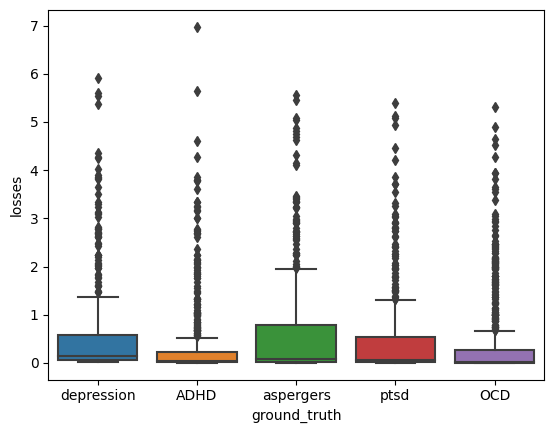

In [ ]:
sns.boxplot(data = df, y = "losses", x = "ground_truth")

<ipython-input-29-264ff7ad7ebf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, )


<Axes: >

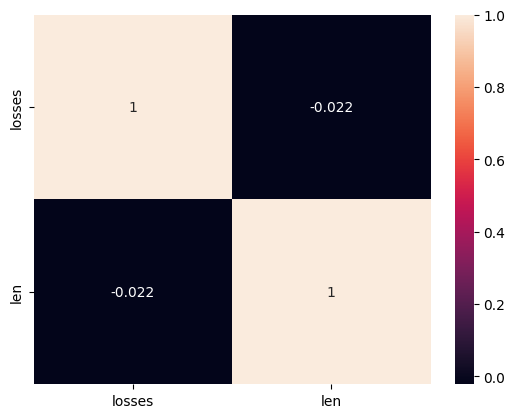

In [ ]:
sns.heatmap(df.corr(), annot=True, )

<Axes: xlabel='predictions', ylabel='losses'>

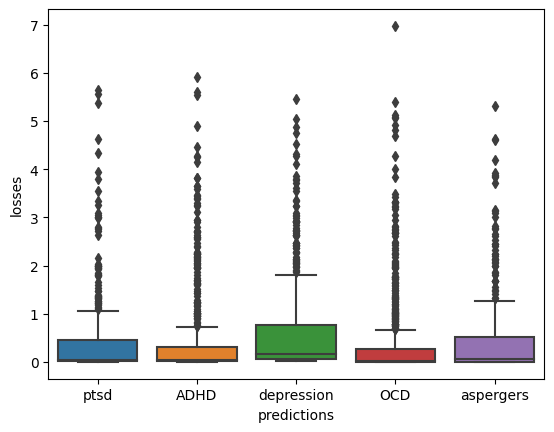

In [ ]:
sns.boxplot(data = df, y = "losses", x = "predictions")

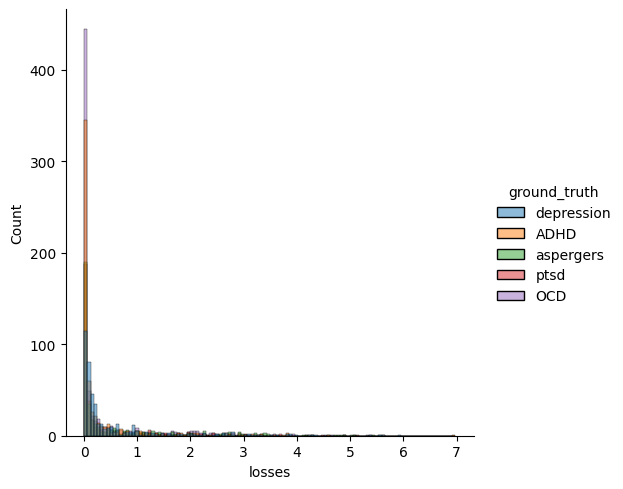

In [ ]:
sns.displot(df, x="losses", hue="ground_truth")

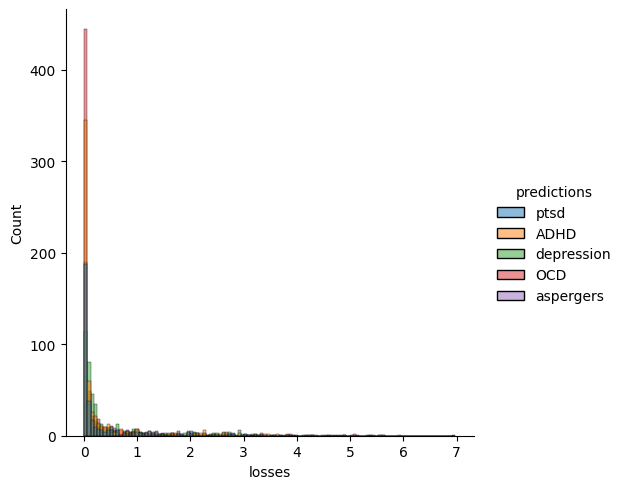

In [ ]:
sns.displot(df, x="losses", hue="predictions")

In [ ]:
bad_predictions = df[df.predictions != df.ground_truth]

In [ ]:
bad_predictions.describe()

,losses,len
count,434.000000,434.000000
mean,2.211976,870.046083
std,1.135830,950.347824
min,0.747781,36.000000
25%,1.304229,334.500000
50%,1.989166,595.000000
75%,2.790711,1017.750000
max,6.974964,7370.000000


<Axes: ylabel='Density'>

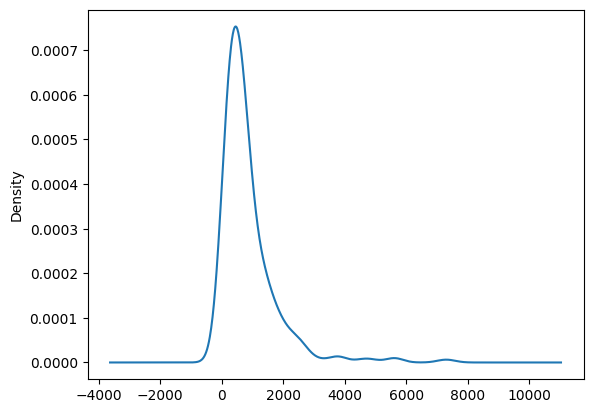

In [ ]:
bad_predictions.len.plot(kind="kde")